<a href="https://colab.research.google.com/github/anyfish/Transformers_SpainAI/blob/main/%5BSpainAI_02%5DLSTM_NLP_clasificador_novelas_espa%C3%B1ol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto usando LSTMs con TensorFlow 2.0

Vamos a crear una Red Neuronal Recurrente (BiLSTM) capaz de clasificar si una secuencia de una novela pertenece a Benito Pérez Galdós o Emilia Pardo Bazán.
 - Idea y preparación del dataset de [Javier de La Rosa](https://twitter.com/versae)

## Importamos las bibliotecas requeridas

In [ ]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm # Barra de progreso
import requests
print(tf.__version__)

2.8.2


## Descarga del dataset

Descargaremos 3 novelas por autor

In [ ]:
URLS = [
    ("galdos", "http://www.gutenberg.org/cache/epub/52392/pg52392.txt"),  # Miau
    ("galdos", "http://www.gutenberg.org/cache/epub/15725/pg15725.txt"),  # Doña Perfecta
    ("galdos", "http://www.gutenberg.org/cache/epub/17013/pg17013.txt"),  # Fortunata y Jacinta
    ("bazan", "https://www.gutenberg.org/files/65632/65632-0.txt"),  # La prueba
    ("bazan", "https://www.gutenberg.org/files/58059/58059-0.txt"),  # La Madre Naturaleza
    ("bazan", "https://www.gutenberg.org/cache/epub/17491/pg17491.txt"),  # La Tribuna
]

galdos = ""
bazan = ""
for author, url in tqdm(URLS):
    work_text = requests.get(url).text
    start_mark = "START OF "
    end_mark = "END OF "
    work_text = work_text[work_text.index(start_mark):work_text.index(end_mark)]
    if author == "galdos":
        galdos += "\n" + work_text
    else:
        bazan += "\n" + work_text

100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Vamos a dividir las novelas en secuencias de una longitud de 250 palabras. Podemos probar con una longitud superior e inferior. Al fin y al cabo es un parámetro a tener en cuenta cuando se define una RNN

In [ ]:
n = 250

galdos_splits = galdos.split()
galdos_chunks = [galdos_splits[i:i + n] for i in range(0, len(galdos_splits), n)]

bazan_splits = bazan.split()
bazan_chunks = [bazan_splits[i:i + n] for i in range(0, len(bazan_splits), n)]

Ahora construiremos una tabla (`DataFrame`) con los textos de cada extracto y una segunda columna indicando si pertenecen la obra de Galdós con un 1 o de Pardo Bazán con un 0.

In [ ]:
galdos_len = len(galdos_chunks)
bazan_len = len(bazan_chunks)
galdos_len, bazan_len 

(2426, 868)

In [ ]:
galdos_df = pd.DataFrame(
    [" ".join(chunk) for chunk in galdos_chunks],
    columns=["text"]
).assign(labels=1).sample(frac=1).reset_index(drop=True)
bazan_df = pd.DataFrame(
    [" ".join(chunk) for chunk in bazan_chunks],
    columns=["text"]
).assign(labels=0).sample(frac=1).reset_index(drop=True)

In [ ]:
galdos_df

,text,labels
0,Él y Barbarita no habían ido ni siquiera a Cha...,0
1,"vais á morir!...» Llamaron, y les abrió una mu...",0
2,no me acuerdo del título; es valenciano y algo...,0
3,Santísima?... Porque ya empezaba a ser viejo y...,0
4,"en voz alta añadió, creyendo en la posibilidad...",0
...,...,...
2421,estaba su prima. Reuniéronse y la arropó cuida...,0
2422,de Shakespeare. Pero después de aquella sacudi...,0
2423,cuidaban de no responderle ó de hablarle con b...,0
2424,con el cuerpo que... ya le digo que la deslomo...,0


In [ ]:
bazan_df

,text,labels
0,el edificio por todos lados. No sólo las que e...,0
1,divierta conmigo! JesÃºs... Â¡ay Dios! LlevÃ³s...,0
2,murmurando no sÃ© quÃ© fÃ³rmulas de cortesÃ­a:...,0
3,"los carlistas medran, pululan, brotan por toda...",0
4,tacón de plano en la inflamada mejilla que vio...,0
...,...,...
863,"¡saludan a todos y se ríen para todos!, ¡repub...",0
864,--Â¡Boba! Â¡Gran milagro! Supe que unos hombre...,0
865,hace mil años.... Esa fresa es mía --exclamó a...,0
866,que amagaban tempestad. No por eso había menos...,0


## División de los datasets

In [ ]:
train_df = pd.concat(
    [galdos_df[:int(galdos_len*.2)], bazan_df[:int(bazan_len*.2)]],
    ignore_index=True
).sample(frac=1).reset_index(drop=True)
train_df

,text,labels
0,"la providencia del Dracón administrativo, dici...",1
1,"cuchillo, y diciendo: «¡Re-hostia con la Repób...",1
2,popular poetry. He is the hero of one of the e...,1
3,Ã¡ estas horas estÃ¡ en la cama con un mal. Ob...,0
4,"el último año, y lo más pronto que le fuera po...",1
...,...,...
653,"uno como el otro, y entonces sí que debíamos m...",1
654,de servir para nada. Mareaba a Cristo con sus ...,1
655,"Por fin, echó una voz que parecía infantil, vo...",1
656,idea u otra semejante le refrescaba el recuerd...,1


In [ ]:
eval_df = pd.concat(
    [galdos_df[int(galdos_len*.8):], bazan_df[int(bazan_len*.8):]],
    ignore_index=True
).sample(frac=1).reset_index(drop=True)
eval_df

,text,labels
0,más encomiástico--. No le dé usted otro nombre...,1
1,"comprar, se acabó la guerra. --¡Pero, hombre.....",1
2,and more tragic situations have been imagined ...,1
3,"en un extremo de la casa, y Fortunata en otro....",1
4,danzas_ que podían costarle caras. Dígase lo q...,1
...,...,...
655,"el madrugador un desteñido pantalón grancé, re...",0
656,pollita. El de los mostachos consideraba a la ...,0
657,D. Juanito de Santa Cruz. --Usted está loco --...,1
658,la rechazaba por ser demasiado absurda y no ca...,1


In [ ]:
train_df['labels'].value_counts()

1    485
0    173
Name: labels, dtype: int64

In [ ]:
eval_df['labels'].value_counts()

1    486
0    174
Name: labels, dtype: int64

## Definimos algunos parámetros de la red

 - vocab_size = cómo de largo queremos que sea nuestro vocabulario. Si es demasiado corto, el rendimiento de la red sería muy pobre pues habría muchos tokens desconocidos. Si es demasiado grande, nuestra red tardará más en entrenar.

 - embedding_dim: Este parámetro nos dice cómo de grandes queremos que sean los vectores que representan cada palabra de nuestro vocabulario. Normalmente, cuanto más grandes sean, mayor 'calidad' en la representación de las mismas.

 - max_length: Debemos definir una longitud máxima de secuencia puesto que nuestra red espera que todas tenga la misma longitud. En nuestro caso, como partimos el dataset en secuencias de 250 palabras, usaremos ese valor.

 - trunc_type: si una secuencia es más larga de 250 palabras la cortamos por detrás (post).

- padding_type = nos dice que en caso de que la secuencia se más corta de 250 tokens en qué parte de ésta se añade los tokens de padding (post = al final).

- oov_tok = `<OOV>` da un valor a las palabras/tokens que estén fuera de esas 5000 como máximo que hemos definido para nuestro vocabulario.


In [ ]:
vocab_size = 5000
embedding_dim = 64
max_length = 250
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
train_articles = train_df['text'].tolist()
train_labels = train_df['labels'].tolist()

validation_articles = eval_df['text'].tolist()
validation_labels = eval_df['labels'].tolist()

print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

658
658
660
660


## Creamos el Tokenizer

Le vamos a decir cuál es el número máximo de palabras, el token para palabras que no estén en el vocabulario y que las pase minúsculas para reducir el tamaño del mismo

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, lower=True)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'a': 7,
 'de': 2,
 'el': 6,
 'en': 8,
 'la': 4,
 'no': 9,
 'que': 3,
 'se': 10,
 'y': 5}

No hemos filtrado las `STOPWORDS` pero se podría.

Tokenizamos nuestro dataset de entrenamiento una vez que ya tenemos nuestro vocabulario listo.

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[1, 15, 204, 18, 45, 3, 78, 9, 42, 636, 344, 5, 3, 18, 1, 23, 646, 362, 1, 15, 712, 8, 4, 411, 70, 170, 18, 2858, 6, 1, 5, 1129, 22, 88, 286, 2855, 8, 6, 987, 2, 4521, 495, 1, 13, 286, 8, 624, 1, 3, 266, 1, 27, 3, 1, 1120, 70, 170, 5, 25, 1, 8, 6, 412, 2, 15, 310, 2859, 2, 4522, 10, 1, 7, 3500, 535, 27, 1, 4523, 6, 97, 19, 73, 293, 1, 2, 16, 3, 3501, 1060, 272, 26, 71, 4524, 95, 26, 71, 1, 1, 168, 1, 99, 1627, 6, 2860, 3, 9, 216, 379, 8, 237, 791, 24, 48, 101, 1, 2, 203, 71, 386, 370, 5, 11, 13, 88, 2, 2424, 5, 95, 88, 2, 3502, 5, 89, 4525, 89, 4525, 1338, 186, 2812, 29, 30, 1, 9, 1130, 31, 204, 29, 105, 73, 1844, 8, 83, 713, 10, 19, 1628, 20, 2425, 21, 1345, 1, 7, 41, 106, 2, 1, 400, 3, 1, 20, 1629, 797, 157, 121, 169, 52, 10, 458, 8, 1061, 52, 9, 10, 458, 26, 1, 86, 3, 199, 1, 20, 102, 3, 16, 1, 46, 1346, 46, 5, 3, 10, 1347, 1, 8, 1, 8, 2098, 1, 1, 1845, 4526, 5, 8, 1846, 1, 28, 80, 8, 2861, 1, 25, 2862, 257, 81, 164, 52, 222, 3, 54, 1, 1, 23, 99, 12, 2426, 24, 13, 679, 3, 1847, 4, 9

Aplicamos padding a nuestras secuencias de entrenamientoi para que todas tengan la misma longitud (para este dataset no es neceario porque las dividimos con la misma longitud, pero en otros casos suele ser útil).

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

255
250
254
250
250
250


In [ ]:
print(train_padded[10])

[   1   15  204   18   45    3   78    9   42  636  344    5    3   18
    1   23  646  362    1   15  712    8    4  411   70  170   18 2858
    6    1    5 1129   22   88  286 2855    8    6  987    2 4521  495
    1   13  286    8  624    1    3  266    1   27    3    1 1120   70
  170    5   25    1    8    6  412    2   15  310 2859    2 4522   10
    1    7 3500  535   27    1 4523    6   97   19   73  293    1    2
   16    3 3501 1060  272   26   71 4524   95   26   71    1    1  168
    1   99 1627    6 2860    3    9  216  379    8  237  791   24   48
  101    1    2  203   71  386  370    5   11   13   88    2 2424    5
   95   88    2 3502    5   89 4525   89 4525 1338  186 2812   29   30
    1    9 1130   31  204   29  105   73 1844    8   83  713   10   19
 1628   20 2425   21 1345    1    7   41  106    2    1  400    3    1
   20 1629  797  157  121  169   52   10  458    8 1061   52    9   10
  458   26    1   86    3  199    1   20  102    3   16    1   46 1346
   46 

Hacemos lo propio con el dataset de validación

In [ ]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

660
(660, 250)


Codificamos correctamente las `labels`

In [ ]:
training_label_seq = np.array(train_labels, dtype=np.int8)
validation_label_seq = np.array(validation_labels, dtype=np.int8)
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

1
1
1
(658,)
1
1
1
(660,)


Veamos cómo somos capaces de decodificar una secuencia tokenizada a texto de nuevo gracias al tokenizer que creamos

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

<OOV> su tía le dijo que fortunata no había venido aún y que le <OOV> para comer maxi <OOV> su sitio en la mesa doña lupe le recogió el <OOV> y volviendo al poco rato sentose en el sofá de paja ambos <OOV> un rato en silencio <OOV> que hoy <OOV> más que <OOV> observó doña lupe y como <OOV> en el rostro de su sobrino señales de desasosiego se <OOV> a entablar conversación más <OOV> «todo el día me he estado <OOV> de lo que hablamos anoche ¡ah si tú fueras otro si tú <OOV> <OOV> pronto <OOV> todos ricos el farmacéutico que no hace dinero en estos tiempos es porque tiene <OOV> de pobre tú sabes bastante y con un poco de trastienda y otro poco de farsa y mucho anuncio mucho anuncio negocio hecho créeme yo te <OOV> no crea usted tía yo también he pensado en eso ayer se me ocurría una aplicación del hierro <OOV> a sin fin de <OOV> creo que <OOV> una fórmula nueva estas cosas hijo o se hacen en gordo o no se hacen si <OOV> algo que sea <OOV> una cosa que lo <OOV> todo absolutamente todo y que

## Construimos nuestra red neuronal

- Utilizaremos la `Sequential` API de Keras
- Creamos una primera capa de `Embedding`que tiene por tamaño `vocab_size`x `embedding_dim`
- Despues añadimos nuestra capa de recurrencia. En este caso será una `LSTM` bidireccional (aprende de izquerida a derecha y de derecha a izquierda)
- Conectamos la salida de esa capa a una capa `Dense`.
- Por último, conectamos todo a una capa `Dense`con función de activación `sigmoid`ya que nuestro problema de clasificación es binario.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 394,369
Trainable params: 394,369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Entrenamos nuestro modelo

In [ ]:
num_epochs = 4
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/4
21/21 - 8s - loss: 0.6390 - accuracy: 0.7158 - val_loss: 0.5759 - val_accuracy: 0.7364 - 8s/epoch - 386ms/step
Epoch 2/4
21/21 - 4s - loss: 0.5374 - accuracy: 0.7371 - val_loss: 0.5160 - val_accuracy: 0.7364 - 4s/epoch - 207ms/step
Epoch 3/4
21/21 - 4s - loss: 0.2707 - accuracy: 0.8845 - val_loss: 0.2464 - val_accuracy: 0.9333 - 4s/epoch - 206ms/step
Epoch 4/4
21/21 - 5s - loss: 0.1382 - accuracy: 0.9590 - val_loss: 0.2664 - val_accuracy: 0.9152 - 5s/epoch - 220ms/step


## Visualizamos los resultados

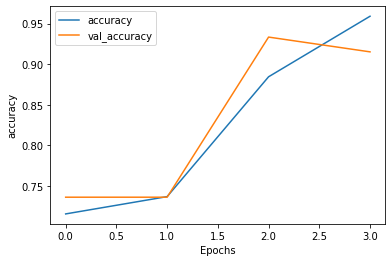

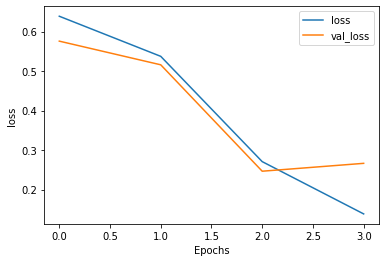

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Probemos nuestro modelo

In [ ]:
validation_articles[50], validation_label_seq[50]

('hace mil años.... Esa fresa es mía --exclamó arrebatando una que Amparo llevaba a sus labios. Ella se la dejó robar, confusa, ruborizada y satisfecha. --¿Y a su casa... tampoco va usted? --Tampoco... no seas celosa, chica. ¿Por qué hemos de hablar siempre de la de García, y no de ti? ¡De nosotros!--añadió con expresión de contenida vehemencia. Sintió la muchacha como una ola de fuego que la envolvía desde la planta de los pies hasta la raíz del cabello, y después un leve frío que le agolpó la sangre al corazón. Borrén se aproximó a la amante pareja, abriendo las manos llenas de tierra y de fresas despachurradas. --Ya me duelen los riñones de andar a gatas--dijo--. Podíamos merendar... si a ustedes no les molesta, pollos. --Por mí...--murmuró Amparo. Ana se acercaba también, trayendo una servilleta anudada, que desató y tendió sobre el brocal del pozo. Reducíase la merienda a unos pastelillos de dulce y una botella de moscatel, regalo de Baltasar. Fueles preciso beber por un mismo vas

In [ ]:
txt = ['''
para que el triunfo fuese completo era menester que a Maxi le entrase una enfermedad asquerosa, repugnante y pestífera, de esas que ahuyentan hasta a los más allegados. Ella, entonces, daría pruebas de ser tan ángel como otra cualquiera, y tendría alma, paciencia, valor y estómago para todo. «Y entonces vería _esa_ si aquí hay perfecciones o no hay perfecciones, y que cada una es cada una... Lo malo sería que no lo viese, porque acá no ha de venir...». Maximiliano la distrajo de esta meditación, dando quejidos profundos. Ya conocía aquello su mujer y sabía el remedio, que era volverlo suavemente del otro lado... «¡Qué sueño!--murmuró Maxi medio despierto--. Soñaba que te habías marchado... y yo te había cogido de un pie, y tú tirabas, y yo tiraba más, y tirando se me rompía la bolsa del aneurisma, y todo el cuarto se llenaba de sangre, todo el cuarto, hasta el techo...». Le arrulló para que se durmiera, y ella se durmió también. Levantose temprano porque tenía que trabajar. Después de las nueve, cuando entró en la alcoba a ver si a su marido se le ofrecía alguna cosa, este se estaba vistiendo, y en una disposición de ánimo muy distinta de la que tuviera la noche anterior. No sólo parecía recobrado de su debilidad, sino que estaba inquieto, ágil y como si acabara de tomar un excitante muy enérgico. En cuanto entró su mujer, se fue derecho a ella, abotonándose el cuello de la camisa, y en tono
''']
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print(pred)
print("Parece una secuencia de una novela de Galdós" if pred[0] > 0.5 else "Parece que esta novela pertenece a Emilia Pardo Bazán")

[[0.9890648]]
Parece una secuencia de una novela de Galdós
